In [10]:
import os
import pandas as pd
import rasterio
import xarray as xr
import requests
import geoviews as gv
import holoviews as hv
import hvplot.xarray
import hvplot.pandas
import shapely
#import numpy as np

import dask
from dask_kubernetes import KubeCluster
from dask.distributed import Client
from dask.distributed import wait, progress

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# Set environment variables for cloud-optimized-geotiffs efficiency
#os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='YES'
#os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS']='TIF'

env = rasterio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                  CPL_VSIL_CURL_USE_HEAD=False,
                  CPL_VSIL_CURL_ALLOWED_EXTENSIONS='TIF',
                  #CPL_DEBUG=True,
                  #CPL_CURL_VERBOSE=True,
                  #VSI_CACHE=True, #The cache size defaults to 25 MB, but can be modified by setting the configuration option VSI_CACHE_SIZE (in bytes). Content in that cache is discarded when the file handle is closed.
                 )

In [12]:
def query_cmr_landsat(collection='Landsat_8_OLI_TIRS_C1',tier='T1', path=47, row=27):
    """Query NASA CMR for Collection1, Tier1 Landsat scenes from a specific path and row."""
    
    data = [f'short_name={collection}',
            f'page_size=2000',
            f'attribute[]=string,CollectionCategory,{tier}',
            f'attribute[]=int,WRSPath,{path}',
            f'attribute[]=int,WRSRow,{row}',
           ]

    query = 'https://cmr.earthdata.nasa.gov/search/granules.json?' + '&'.join(data)

    r = requests.get(query, timeout=100)
    print(r.url)
    
    df = pd.DataFrame(r.json()['feed']['entry'])
    
    # Save results to a file
    #print('Saved results to cmr-result.json')
    #with open('cmr-result.json', 'w') as j:
    #    j.write(r.text)
    
    return df

In [13]:
def make_google_archive(pids, bands):
    """Turn list of product_ids into pandas dataframe for NDVI analysis."""
    
    path =  pids[0].split('_')[2][1:3]
    row =  pids[0].split('_')[2][-2:]
    baseurl = f'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/0{path}/0{row}'
    
    dates = [pd.to_datetime(x.split('_')[3]) for x in pids]
    df = pd.DataFrame(dict(product_id=pids, date=dates))
    
    for band in bands:
        df[band] = [f'{baseurl}/{x}/{x}_{band}.TIF' for x in pids]
    
    return df

In [14]:
df = query_cmr_landsat(path=2, row=60)
df1 = query_cmr_landsat(path=1, row=60)

https://cmr.earthdata.nasa.gov/search/granules.json?short_name=Landsat_8_OLI_TIRS_C1&page_size=2000&attribute%5B%5D=string,CollectionCategory,T1&attribute%5B%5D=int,WRSPath,2&attribute%5B%5D=int,WRSRow,60
https://cmr.earthdata.nasa.gov/search/granules.json?short_name=Landsat_8_OLI_TIRS_C1&page_size=2000&attribute%5B%5D=string,CollectionCategory,T1&attribute%5B%5D=int,WRSPath,1&attribute%5B%5D=int,WRSRow,60


In [15]:
# Holoviews maps are interactive, you can zoom in with the magnifying glass tool
coordlist = df.polygons.iloc[0]
lats = coordlist[0][0].split(' ')[::2]
lons = coordlist[0][0].split(' ')[1::2]
coords = [(float(lon),float(lat)) for lon, lat in zip(lons,lats)]
poly = shapely.geometry.Polygon(coords)
buffer = 1 #degrees
left, bottom, right, top  = poly.bounds

footprint = gv.Shape(poly, label=df.title.iloc[0]).options(alpha=0.5)
tiles = gv.tile_sources.CartoEco.options(width=700, height=500).redim.range(Latitude=(bottom-1, top+1), Longitude=(left-1,right+1)) 
labels = gv.tile_sources.StamenLabels.options(level='annotation')
tiles * footprint * labels

:Overlay
   .WMTS.I                                         :WMTS   [Longitude,Latitude]
   .Shape.LC08_L1TP_002060_20130405_20170505_01_T1 :Shape   [Longitude,Latitude]
   .WMTS.II                                        :WMTS   [Longitude,Latitude]

In [16]:
# Get all scenes for a given path and row, bands 4 and 5
pids = df.title.tolist()
# Don't use the most recent date since there can be a lag in data being on Google Storage
df = make_google_archive(pids[:-1], ['B4', 'B5'])


pids = df1.title.tolist()
df1 = make_google_archive(pids[:-1], ['B4', 'B5'])

In [17]:
df.head()
df.tail()

,product_id,date,B4,B5
86,LC08_L1TP_002060_20191105_20191115_01_T1,2019-11-05,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
87,LC08_L1TP_002060_20200108_20200114_01_T1,2020-01-08,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
88,LC08_L1TP_002060_20200124_20200128_01_T1,2020-01-24,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
89,LC08_L1TP_002060_20200209_20200211_01_T1,2020-02-09,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
90,LC08_L1TP_002060_20200225_20200313_01_T1,2020-02-25,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...


In [18]:
# Select 10 'workers' under 'manual scaling' menu below and click 'Scale'
# Click on the 'Dashboard link' to monitor calculation progress
cluster = KubeCluster(n_workers=30)
cluster

distributed.scheduler - INFO - Clear task state
/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.scheduler - INFO -   Scheduler at:   tcp://10.32.16.13:39307
distributed.scheduler - INFO -   dashboard at:                    :42003


In [19]:
# Attach Dask to the cluster
client = Client(cluster)

distributed.scheduler - INFO - Receive client connection: Client-cd68f768-77b0-11ea-8581-967e6132cacb
distributed.core - INFO - Starting established connection


In [20]:
# Load with rasterio
image_url = df.iloc[5]['B4']
with env:
    with rasterio.open(image_url) as src:
        width = src.width
        blockx = src.profile['blockxsize']
        blocky = src.profile['blockysize']
        print(src.profile)
        
# Load with rasterio
image_url1 = df1.iloc[5]['B4']
with env:
    with rasterio.open(image_url1) as src1:
        width = src1.width
        blockx = src1.profile['blockxsize']
        blocky = src1.profile['blockysize']
        print(src1.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7601, 'height': 7751, 'count': 1, 'crs': CRS.from_epsg(32619), 'transform': Affine(30.0, 0.0, 704385.0,
       0.0, -30.0, 115815.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7581, 'height': 7741, 'count': 1, 'crs': CRS.from_epsg(32620), 'transform': Affine(30.0, 0.0, 212385.0,
       0.0, -30.0, 115815.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [21]:
# Note that the blocksize of the image is 256 by 256, so we want xarray to use some multiple of that
xchunk = int(width/blockx)*blockx
ychunk = blocky
with env:
    da = xr.open_rasterio(image_url, chunks={'band': 1, 'x': xchunk, 'y': ychunk})
da

with env:
    da1 = xr.open_rasterio(image_url1, chunks={'band': 1, 'x': xchunk, 'y': ychunk})
da1

<xarray.DataArray (band: 1, y: 7741, x: 7581)>
dask.array<open_rasterio-6a81795f4860a9150bbecd292f3b1e74<this-array>, shape=(1, 7741, 7581), dtype=uint16, chunksize=(1, 256, 7424), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 1.158e+05 1.158e+05 1.157e+05 ... -1.164e+05 -1.164e+05
  * x        (x) float64 2.124e+05 2.124e+05 2.125e+05 ... 4.398e+05 4.398e+05
Attributes:
    transform:      (30.0, 0.0, 212385.0, 0.0, -30.0, 115815.0)
    crs:            +init=epsg:32620
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point

In [22]:
band1 = da.sel(band=1).persist()
#img = band1.hvplot(rasterize=True, dynamic=True, width=700, height=500, cmap='magma')
#img=band1.hvplot(rasterize=True, dynamic=True, cmap='magma')
#img

#doesn't work even on tutorial

In [23]:
# Note that these landsat images are not necessarily the same shape or on the same grid:
for image_url in df.B4[:5]:
    with env:
        with rasterio.open(image_url) as src:
            print(src.shape, src.bounds)
            
for image_url1 in df1.B4[:5]:
    with env:
        with rasterio.open(image_url1) as src:
            print(src.shape, src.bounds)

(7321, 7351) BoundingBox(left=685785.0, bottom=-110115.0, right=906315.0, top=109515.0)
(7751, 7591) BoundingBox(left=707085.0, bottom=-116715.0, right=934815.0, top=115815.0)
(7751, 7601) BoundingBox(left=704685.0, bottom=-116715.0, right=932715.0, top=115815.0)
(7751, 7601) BoundingBox(left=706185.0, bottom=-116715.0, right=934215.0, top=115815.0)
(7751, 7591) BoundingBox(left=706785.0, bottom=-116715.0, right=934515.0, top=115815.0)
(7301, 7491) BoundingBox(left=212685.0, bottom=-109815.0, right=437415.0, top=109215.0)
(7301, 7501) BoundingBox(left=209385.0, bottom=-109815.0, right=434415.0, top=109215.0)
(7301, 7491) BoundingBox(left=213885.0, bottom=-109815.0, right=438615.0, top=109215.0)
(7741, 7591) BoundingBox(left=210585.0, bottom=-116415.0, right=438315.0, top=115815.0)
(7741, 7591) BoundingBox(left=209385.0, bottom=-116415.0, right=437115.0, top=115815.0)


In [24]:
def create_multiband_dataset(row, bands=['B4','B5'], chunks={'band': 1, 'x': xchunk, 'y': ychunk}):
    '''A function to load multiple landsat bands into an xarray dataset 
    
    '''
    
    # Each image is a dataset containing both band4 and band5
    datasets = []
    for band in bands:
        url = row[band]
        with env:
            da = xr.open_rasterio(url, chunks=chunks)
        da = da.squeeze().drop(labels='band')
        ds = da.to_dataset(name=band)
        datasets.append(ds)

    DS = xr.merge(datasets)
    
    return DS

In [25]:
# Merge all acquisitions into a single large Dataset, this will take a minute
datasets = []
for i,row in df.iterrows():
    try:
        print(i, 'loading...', row.date)
        ds = create_multiband_dataset(row)
        datasets.append(ds)
    except Exception as e:
        print('ERROR loading, skipping acquistion!')
        print(e)

datasets1 = []
for i,row in df1.iterrows():
    try:
        print(i, 'loading...', row.date)
        ds = create_multiband_dataset(row)
        datasets1.append(ds)
    except Exception as e:
        print('ERROR loading, skipping acquistion!')
        print(e)

0 loading... 2013-04-05 00:00:00
1 loading... 2013-06-29 00:00:00
2 loading... 2013-09-01 00:00:00
3 loading... 2013-09-17 00:00:00
4 loading... 2013-10-19 00:00:00
5 loading... 2013-12-06 00:00:00
6 loading... 2014-01-07 00:00:00
7 loading... 2014-01-23 00:00:00
8 loading... 2014-04-13 00:00:00
9 loading... 2014-05-31 00:00:00
10 loading... 2014-06-16 00:00:00
11 loading... 2014-07-18 00:00:00
12 loading... 2014-08-03 00:00:00
13 loading... 2014-09-04 00:00:00
14 loading... 2014-09-20 00:00:00
15 loading... 2014-10-06 00:00:00
16 loading... 2014-10-22 00:00:00
17 loading... 2014-11-07 00:00:00
18 loading... 2014-11-23 00:00:00
19 loading... 2014-12-09 00:00:00
20 loading... 2015-01-26 00:00:00
21 loading... 2015-02-11 00:00:00
ERROR loading, skipping acquistion!
HTTP response code: 404 - Failed writing header
22 loading... 2015-02-27 00:00:00
23 loading... 2015-03-15 00:00:00
24 loading... 2015-05-02 00:00:00
25 loading... 2015-06-03 00:00:00
26 loading... 2015-07-05 00:00:00
27 loadi

In [26]:
# Create an xarray dataset
# This takes a while to expand dimensions
dim=pd.DatetimeIndex(df.date.tolist(), name='time')
dim=dim.delete(21)
dim
DS = xr.concat(datasets, dim)
print('Dataset size (Gb): ', DS.nbytes/1e9)

Dataset size (Gb):  93.432543936


In [27]:
dim1=pd.DatetimeIndex(df1.date.tolist(), name='time')
dim1
DS1=xr.concat(datasets1, dim1)
print('Dataset size (Gb): ', DS1.nbytes/1e9)

Dataset size (Gb):  100.930998536


In [28]:
#mergedData = xr.merge([DS, DS1])
#print('Dataset size (Gb): ', DS1.nbytes/1e9)

#makes it crash

distributed.scheduler - INFO - Register tcp://10.32.35.3:33307
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.35.3:33307
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.35.2:46657
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.35.2:46657
distributed.core - INFO - Starting established connection


In [29]:
#mergedData = xr.merge([DS, DS1], join='left')
#print('Dataset size (Gb): ', mergedData.nbytes/1e9)

#crashes as well

In [30]:
# Set chunks now
#xchunk = int(DS.dims['x']/blockx)*blockx
xchunk = DS.dims['x']
chunks = {'x': xchunk, 'y': ychunk}
DS = DS.chunk(chunks)
DS

<xarray.Dataset>
Dimensions:  (time: 90, x: 8371, y: 7751)
Coordinates:
  * y        (y) float64 -1.167e+05 -1.167e+05 ... 1.158e+05 1.158e+05
  * x        (x) float64 6.858e+05 6.858e+05 6.859e+05 ... 9.369e+05 9.369e+05
  * time     (time) datetime64[ns] 2013-04-05 2013-06-29 ... 2020-02-25
Data variables:
    B4       (time, y, x) float64 dask.array<chunksize=(1, 256, 8371), meta=np.ndarray>
    B5       (time, y, x) float64 dask.array<chunksize=(1, 256, 8371), meta=np.ndarray>

In [31]:
# Again, only metadata is retrieved at this point, wich is why it's so quick!
da = DS.sel(time='2017-05-23')['B4']
print('Image size (Gb): ', da.nbytes/1e9)
da

Image size (Gb):  0.519068968


<xarray.DataArray 'B4' (y: 7751, x: 8371)>
dask.array<getitem, shape=(7751, 8371), dtype=float64, chunksize=(256, 8371), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -1.167e+05 -1.167e+05 ... 1.158e+05 1.158e+05
  * x        (x) float64 6.858e+05 6.858e+05 6.859e+05 ... 9.369e+05 9.369e+05
    time     datetime64[ns] 2017-05-23
Attributes:
    crs:            +init=epsg:32619
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point

In [32]:
NDVI = (DS['B5'] - DS['B4']) / (DS['B5'] + DS['B4'])
NDVI

<xarray.DataArray (time: 90, y: 7751, x: 8371)>
dask.array<truediv, shape=(90, 7751, 8371), dtype=float64, chunksize=(1, 256, 8371), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -1.167e+05 -1.167e+05 ... 1.158e+05 1.158e+05
  * x        (x) float64 6.858e+05 6.858e+05 6.859e+05 ... 9.369e+05 9.369e+05
  * time     (time) datetime64[ns] 2013-04-05 2013-06-29 ... 2020-02-25

In [33]:
taps = []
def record_coords(x, y):
    if None not in [x,y]:
        taps.append([x, y])
    return hv.Points(taps)

In [34]:
# NOTE: this will take a minute to load and is best viewed on a wide monitor
# the time slider can get hidden on small screens
img = NDVI.hvplot('x', 'y', groupby='time', dynamic=True, rasterize=True, width=700, height=500, cmap='magma')
tap = hv.streams.SingleTap(transient=True, source=img)
clicked_points = hv.DynamicMap(record_coords, streams=[tap])

img * clicked_points.options(size=10, color='w')

:DynamicMap   [time]
   :Overlay
      .Image.I  :Image   [x,y]   (value)
      .Points.I :Points   [x,y]

In [35]:
# Points clicked are stored in the 'taps list'
if len(taps) == 0:
    taps = [(745800, -26700)]

print('Selected points:')
taps


Selected points:


[(745800, -26700)]

In [36]:
xcen,ycen = taps[0]
buf = 5000  # look at point +/- 5km
ds = NDVI.sel(x=slice(xcen-buf,xcen+buf), y=slice(ycen-buf,ycen+buf))
timeseries = ds.resample(time='1MS').mean().persist()
# Store as pandas series
s = timeseries.to_series() 
s.shape

(9203787,)

In [ ]:
# Holoviews is also great for interative 2D plots
line = s.hvplot(width=700, height=300, legend=False)
points = s.hvplot.scatter(width=700, height=300, legend=False)
label = f'Mean NDVI: easting={xcen:g} , northing={ycen:g}'

(line * points).relabel(label)

distributed.scheduler - INFO - Register tcp://10.32.5.2:37263
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.5.2:37263
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.5.3:35159
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.5.3:35159
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Remove worker tcp://10.32.5.3:35159
distributed.core - INFO - Removing comms to tcp://10.32.5.3:35159
distributed.scheduler - INFO - Remove worker tcp://10.32.5.2:37263
distributed.core - INFO - Removing comms to tcp://10.32.5.2:37263
distributed.core - INFO - Event loop was unresponsive in Scheduler for 23.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [32]:
import tensorflow as tf

tf.enable_eager_execution()
print(tf.__version__)

/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/frame

1.13.1


In [38]:
feature_dims = ['lat', 'lon']

rs = XRReshaper(DS)
data_matrix, _ = rs.to(feature_dims)

# Some linear algebra or machine learning
_,_, eofs = svd(data_matrix)

eofs_datarray = rs.get(eofs[0], ['mode'] + feature_dims)

AttributeError: 'Dataset' object has no attribute 'get_axis_num'

In [39]:
feature_dims = ['lat', 'lon']
pca = XPCA(feature_dims, n_components=10, weight=cos(DS.lat))
pca.fit(DS)
pca.transform(DS)
eofs = pca.components_

NameError: name 'XPCA' is not defined

In [37]:
DS.head()
DS

<xarray.Dataset>
Dimensions:  (time: 90, x: 8371, y: 7751)
Coordinates:
  * y        (y) float64 -1.167e+05 -1.167e+05 ... 1.158e+05 1.158e+05
  * x        (x) float64 6.858e+05 6.858e+05 6.859e+05 ... 9.369e+05 9.369e+05
  * time     (time) datetime64[ns] 2013-04-05 2013-06-29 ... 2020-02-25
Data variables:
    B4       (time, y, x) float64 dask.array<chunksize=(1, 256, 8371), meta=np.ndarray>
    B5       (time, y, x) float64 dask.array<chunksize=(1, 256, 8371), meta=np.ndarray>

In [38]:
DS["newdata"] = (DS['B5'] - DS['B4']) / (DS['B5'] + DS['B4'])

In [39]:
ds

<xarray.DataArray (time: 90, y: 333, x: 333)>
dask.array<getitem, shape=(90, 333, 333), dtype=float64, chunksize=(1, 238, 333), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -3.168e+04 -3.165e+04 ... -2.175e+04 -2.172e+04
  * x        (x) float64 7.408e+05 7.408e+05 7.409e+05 ... 7.508e+05 7.508e+05
  * time     (time) datetime64[ns] 2013-04-05 2013-06-29 ... 2020-02-25

In [40]:
hold = NDVI.iloc(2, 3)

AttributeError: 'DataArray' object has no attribute 'iloc'

In [41]:
NDVI = DS['newdata']

In [42]:
NDVI.attrs = DS.newdata.attrs

In [43]:
NDVI.attrs['units'] = 'vegetation index'

In [44]:
NDVI

<xarray.DataArray 'newdata' (time: 90, y: 7751, x: 8371)>
dask.array<truediv, shape=(90, 7751, 8371), dtype=float64, chunksize=(1, 256, 8371), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -1.167e+05 -1.167e+05 ... 1.158e+05 1.158e+05
  * x        (x) float64 6.858e+05 6.858e+05 6.859e+05 ... 9.369e+05 9.369e+05
  * time     (time) datetime64[ns] 2013-04-05 2013-06-29 ... 2020-02-25
Attributes:
    units:    vegetation index

In [45]:
ndvi1d = NDVI[[5,10]]

(array([2.7900000e+02, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        8.6644800e+05, 5.3595585e+07, 1.6404636e+07, 1.2250315e+07,
        2.8700000e+02, 6.8500000e+02]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

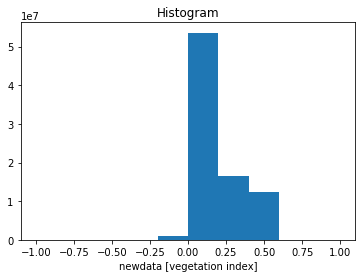

In [46]:
ndvi1d.plot()

In [47]:
ndvi2 = NDVI.isel(x = 2000, y =3000)

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


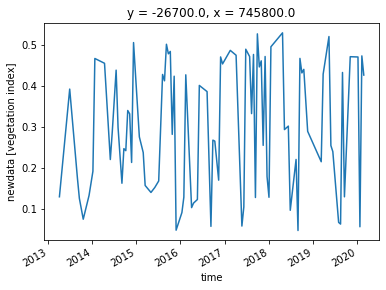

In [48]:
ndvi2.plot()


In [49]:
ndvi2

<xarray.DataArray 'newdata' (time: 90)>
dask.array<getitem, shape=(90,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    y        float64 -2.67e+04
    x        float64 7.458e+05
  * time     (time) datetime64[ns] 2013-04-05 2013-06-29 ... 2020-02-25
Attributes:
    units:    vegetation index

In [50]:
NDVI.to_dataframe()

KeyboardInterrupt: 

In [56]:
import xlearn as xlr
from xlearn.cluster import KMeans
import xarray as xr
import numpy as np

#da = xr.DataArray(np.random.randn(100, 2, 3))


ModuleNotFoundError: No module named 'xlr'

In [60]:
new = NDVI[:20]

In [ ]:
m = KMeans(n_clusters=4, random_state=0).fit(new)

distributed.core - INFO - Event loop was unresponsive in Scheduler for 8.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.scheduler - INFO - Register tcp://10.32.33.3:42561
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.33.3:42561
distributed.core - INFO - Starting established connection
distributed.core - INFO - Event loop was unresponsive in Scheduler for 7.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.scheduler - INFO - Register tcp://10.32.33.2:39517
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.33.2:39517
distributed.core - INFO - Starting established connection


In [57]:
import xarray as xr
from sklearn.cluster import KMeans as KMeans_sklearn
import numpy as np
import matplotlib.pyplot as plt

class KMeans(KMeans_sklearn):
    '''Inherit from sklearn.cluster.KMeans that accept xarray.DataArray data
    to fit.'''

    def __init__(self, *args, **kw):
        super().__init__(*args, **kw)
    def __str__(self):
        attrs = ['algorithm', 'copy_x', 'init', 'max_iter',
            'n_clusters', 'n_init', 'n_jobs', 'precompute_distances',
            'random_state', 'tol', 'verbose']
        # s = ', '.join(['{}={}'.format(a, getattr(self, a)) for a in attrs])
        values = []
        for attr in attrs:
            value = getattr(self, attr)
            if isinstance(value, str):
                value = '"{}"'.format(value)
            values.append(value)
        s = ', '.join(['{}={}'.format(attr, value)
            for attr,value in zip(attrs, values)])
        return '[KMeans for xarray]: {}.'.format(s)
    def __repr__(self):
        return self.__str__()

    def fit(self, da):
        '''xarray.DataArray version of sklearn.cluster.KMeans.fit.'''

        # Compatible with the slearn.cluster.KMeans fit method when the input data is not DataArray
        if not isinstance(da, xr.DataArray):
            return super().fit(da)

        # retrieve parameters
        n_samples = da.shape[0]
        samples_dim = da.dims[0]
        samples_coord = {samples_dim: da.coords[samples_dim]}
        features_shape = da.shape[1:]
        n_features = np.prod(features_shape)
        features_dims = da.dims[1:]
        cluster_centers_dims = ('cluster',) + features_dims
        cluster_centers_coords = {'cluster': np.arange(self.n_clusters)}
        for dim in features_dims:
            cluster_centers_coords[dim] = da.coords[dim]

        # transform the input data array
        X = da.data.reshape(n_samples, n_features)# 'data' might be replaced with 'values'.
        # any feature contains np.NaN
        valid_features_index = ~np.isnan(X[0,:])
        X_valid = X[:, valid_features_index]
        super().fit(X_valid)
        self.valid_features_index_ = valid_features_index

        # wrap the estimated parameters into DataArray
        cluster_centers = np.zeros((self.n_clusters, n_features)) + np.NaN
        cluster_centers[:, valid_features_index] = self.cluster_centers_
        self.cluster_centers_da = xr.DataArray(
            cluster_centers.reshape((self.n_clusters,) + features_shape),
            dims=cluster_centers_dims,
            coords=cluster_centers_coords
        )
        self.labels_da = xr.DataArray(self.labels_, dims=samples_dim,
            coords=samples_coord)

        return self

    def predict(self, da):
        '''xarray.DataArray version of sklearn.cluster.KMeans.fit.'''

        # compatible with the sklean.cluster.KMeans predict method when the input data is not DataArray
        if not isinstance(da, xr.DataArray):
            return super().predict(da)

        # retrieve parameters
        n_samples = da.shape[0]
        features_shape = da.shape[1:]
        n_features = np.prod(features_shape)

        X = da.data.reshape(n_samples, n_features)# 'data' might be replaced with 'values'.
        # remove NaN values if exists in X
        try:
            X_valid = X[:, self.valid_features_index_]
        except:
            X_valid = X
        samples_dim = da.dims[0]
        samples_coord = {samples_dim: da.coords[samples_dim]}
        labels = xr.DataArray(super().predict(X_valid),
            dims=samples_dim, coords=samples_coord)

        return labels

    def get_cluster_fraction(self, label):
        '''Get the fraction of a given cluster denoted by label.'''
        return (self.labels_==label).sum()/self.labels_.size

    def plot_cluster_centers(self, label=None, **kw):
        '''Plot maps of cluster centers.'''
        if label is None:
            label = range(self.n_clusters)
        elif isinstance(label, int):
            label = [label,]
        for label_ in label:
            plt.figure()
            try:
                # if the geoplots package is installed
                self.cluster_centers_da.sel(cluster=label_).geo.plot(**kw)
            except:
                self.cluster_centers_da.sel(cluster=label_).plot(**kw)
            title = '{:4.1f}%'.format(self.get_cluster_fraction(label_)*100)
            plt.title(title)